# Extended RNN Model
Die Architektur des Modells basiert auf einem Projektpapier von Jason C. Sullivan der Stanford University. (https://cs230.stanford.edu/projects_fall_2019/reports/26254244.pdf) 

In [1]:
#import necessary libraries
import utils
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

## Variablen
Hier können die Variablen geändert und so das Model optimiert werden

In [2]:
#maximum amount of epochs
EPOCHS = 10000
#batch size
BATCH_SIZE = 64
#amount of trading days
trading_days = 30
#name of the model
model_type = "xtd_rnn"

## Datendownload

In [3]:
#using the download function written in the utils-file
raw_df = utils.download()

## Preprocessing
In diesem Schritt werden folgende Schritte durchgeführt:
1. Die Volatilitätswerte werden berechnet
2. Die Volatilitätszeitreihe wird mithilfe des Augmented-Dickey-Fuller-Tests (ADF-Test) auf Stationarität analysiert
3. Die Volatilitätswerte werden 0-1 normalisiert
4. Die Variablen Input(x) und Output(y) werden erstellt
5. Die Daten werden in Trainingsdatensatz und Testdatensatz geteilt

In [4]:
#create the list of volatility values
x = utils.process(df=raw_df, trading_days=trading_days)
#check stationarity with the ADF-Test
utils.test(x=x)
#Dimension Expansion to create a matrix
x = np.expand_dims(x, 1)
# normalize the dataset
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
#generate the input(x) and output(y) variables
x, y = utils.convert2matrix(data_arr=x, look_back=1)
#Split the data into training and testing datasets
X_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

ADF Statistic: -5.061658
p-value: 0.000017
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


## Modellgeneration
Die Architektur des Modells inklusive Neuronenanzahl wird übernommen. Es gibt ein LSTM-Layer, zwei Dropout-Layers (Dropout-Activation = 0.1), ein Dense Layer und ein GRU-Layer

In [5]:
model = Sequential()
# Input layer
model.add(LSTM(20, input_shape=(X_train.shape[1], 1),return_sequences=True))
model.add(Dropout(0.1))
# Hidden layer
model.add(Dense(units = 10,activation="relu"))
model.add(GRU(10))
model.add(Dropout(0.1))
# Output Layer
model.add(Dense(units = 1))
model.compile(optimizer="adam",loss="mse",metrics=["mse"])

## Modelltraining

In [6]:
#if the validation mse wasn't lowering for 100 epochs, stop the training
early_stop = EarlyStopping(monitor = 'val_mse',
                                               patience = 100)
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split = 0.2,
    verbose=1,
    shuffle=False,
    callbacks = [early_stop]
)

loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/10000
82/82 [==============================] - 5s 17ms/step - loss: 0.0694 - mse: 0.0694 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 2/10000
82/82 [==============================] - 1s 10ms/step - loss: 0.0282 - mse: 0.0282 - val_loss: 0.0130 - val_mse: 0.0130
Epoch 3/10000
82/82 [==============================] - 1s 9ms/step - loss: 0.0256 - mse: 0.0256 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 4/10000
82/82 [==============================] - 1s 9ms/step - loss: 0.0222 - mse: 0.0222 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 5/10000
82/82 [==============================] - 1s 9ms/step - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 6/10000
82/82 [==============================] - 1s 9ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 7/10000
82/82 [==============================] - 1s 9ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 7.7733e-04 - val_mse: 7.7733e-04
Epoch 8/10000
82/82 [==============================] - 1s 1

## Berechnungen zur Analyse des Modells

In [7]:
#get a list of the epochs
epochs = range(len(loss))
#get the amount of epochs
n_epochs = len(loss)
#predict the volatility based on the testdataset
pred = model.predict(x_test)
#Squeeze the predicition and the test-labels
pred = np.squeeze(pred,1)
y_test = np.squeeze(y_test,1)
#create a DataFrame with the Columns "Actual" and "Prediction"
prediction = utils.compute_prediction_frame(y_labels=y_test,predicted=pred)

## Analyse des Modells
### Scatterplot Regressionslinie

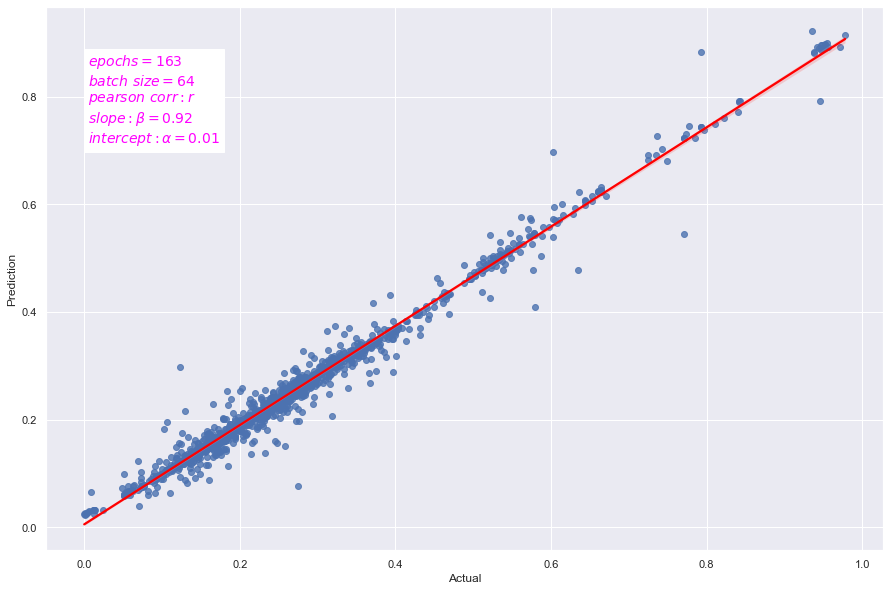

Beta of  Prediction  = 0.9225
Alpha of  Prediction  = 0.0052


In [8]:
utils.scatterplotRegression(df=prediction, model_type=model_type, EPOCHS=n_epochs,BATCH_SIZE=BATCH_SIZE)


### Validation gegen Training Loss 

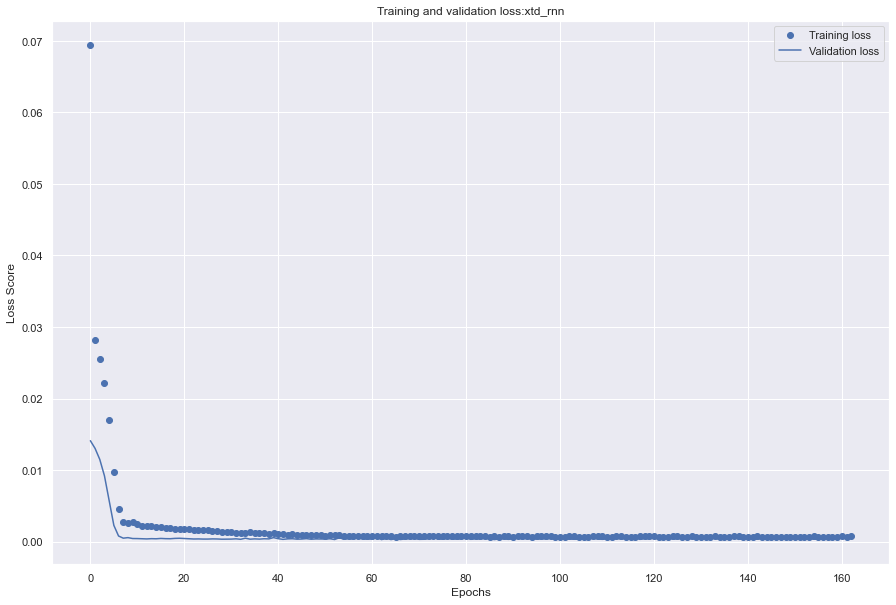

In [9]:
utils.error_evaluation(epochs,loss,val_loss,model_type)

### Berechnung der Fehlermetriken
#### Mean Absolute Error

In [10]:
print(mean_absolute_error(y_true=y_test,y_pred=pred))


0.020466751040721137


#### Root Mean Squared Error

In [11]:
utils.print_error(y_train=y_train,y_test=y_test,train_predict=np.squeeze(model.predict(X_train),1),test_predict=pred)

Train RMSE: 0.028 RMSE
Test RMSE: 0.028 RMSE
